In [1]:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoConfig
from torch.utils.data import DataLoader, Dataset
import numpy as np

# 加载多任务数据集
file_path = 'cti.csv'
multi_task_df = pd.read_csv(file_path)

# 检查和处理空值
multi_task_df.iloc[:, 1:] = multi_task_df.iloc[:, 1:].apply(pd.to_numeric, errors='coerce')  # 将非数值数据转换为NaN
labels = multi_task_df.iloc[:, 1:].values

# 创建标签掩码，标记非空值的位置
label_masks = ~pd.isna(labels)
labels = np.where(pd.isna(labels), -1, labels)  # 用-1填充NaN值
labels = labels.astype(float)  # 确保标签数据是浮点数类型
labels = torch.tensor(labels, dtype=torch.float)
label_masks = torch.tensor(label_masks, dtype=torch.float)

# 指定本地模型路径
model_path = "DeepChem\ChemBERTa-77M-MTR"

# 从本地路径加载分词器和模型配置
tokenizer = AutoTokenizer.from_pretrained(model_path)
config = AutoConfig.from_pretrained(model_path)
config.num_labels = labels.shape[1]  # 动态确定标签数量
config.output_hidden_states = True

# 从本地路径加载具有更新配置的模型
model = AutoModelForSequenceClassification.from_pretrained(model_path, config=config)

print("分词器和模型加载成功。")

# 标记化输入数据
inputs = tokenizer(list(multi_task_df.iloc[:, 0]), padding=True, truncation=True, return_tensors="pt")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
inputs ={key:val.to(device) for key,val in inputs.items()}
labels =labels.to(device)
label_masks=label_masks.to(device)

# 创建数据集对象
class MultiTaskDataset(Dataset):
    def __init__(self, inputs, labels, label_masks):
        self.inputs = inputs
        self.labels = labels
        self.label_masks = label_masks

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.inputs.items()}
        item['labels'] = self.labels[idx]
        item['label_masks'] = self.label_masks[idx]
        return item

dataset = MultiTaskDataset(inputs, labels, label_masks)

# 创建数据加载器
batch_size = 128
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

model.to(device)
# 定义优化器
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)

# 自定义损失函数，忽略掩码位置的计算
def masked_loss(outputs, labels, label_masks):
    loss_fn = torch.nn.BCEWithLogitsLoss(reduction='none')
    # 忽略-1填充的标签
    active_loss = labels != -1
    active_labels = labels[active_loss]
    active_outputs = outputs[active_loss]
    losses = loss_fn(active_outputs, active_labels)
    masked_losses = losses * label_masks[active_loss]
    return masked_losses.sum() / label_masks.sum()

# 训练模型
model.train()
num_epochs = 100
for epoch in range(num_epochs):
    total_loss = 0
    for batch in dataloader:
        optimizer.zero_grad()
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = batch['labels']
        label_masks = batch['label_masks']
        outputs = model(input_ids=input_ids, attention_mask=attention_mask).logits
        loss = masked_loss(outputs, labels, label_masks)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(dataloader)
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {avg_loss}")


# 保存模型
model.save_pretrained("saved_model")
tokenizer.save_pretrained("saved_model")

    

# 获取化学分子的表示和预测值
model.eval()
with torch.no_grad():
    outputs = model(**inputs)
    embeddings = outputs.hidden_states[-1][:, 0, :]  # 获取 [CLS] token 的表示
    predictions = torch.sigmoid(outputs.logits)  # 获取每个标签的预测概率

# 拼接表示和预测值
enhanced_embeddings = torch.cat((embeddings, predictions), dim=1)

print("增强的嵌入表示和预测值获取成功。")


D:\anaconda3\envs\syq\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at DeepChem\ChemBERTa-77M-MTR and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


分词器和模型加载成功。
Epoch 1/100, Loss: 0.6934843129581876
Epoch 2/100, Loss: 0.6917401088608636
Epoch 3/100, Loss: 0.6899714536137052
Epoch 4/100, Loss: 0.6880824300977919
Epoch 5/100, Loss: 0.6860930058691237
Epoch 6/100, Loss: 0.6838345130284628
Epoch 7/100, Loss: 0.6813848680920072
Epoch 8/100, Loss: 0.6782132122251723
Epoch 9/100, Loss: 0.6746518545680575
Epoch 10/100, Loss: 0.670565042230818
Epoch 11/100, Loss: 0.6647962530454
Epoch 12/100, Loss: 0.6589555276764764
Epoch 13/100, Loss: 0.6508004996511672
Epoch 14/100, Loss: 0.6413605345620049
Epoch 15/100, Loss: 0.630285402139028
Epoch 16/100, Loss: 0.6163467698627048
Epoch 17/100, Loss: 0.6010187930530972
Epoch 18/100, Loss: 0.5827209419674344
Epoch 19/100, Loss: 0.562623467710283
Epoch 20/100, Loss: 0.5421025223202176
Epoch 21/100, Loss: 0.5208572612868415
Epoch 22/100, Loss: 0.4997095399432712
Epoch 23/100, Loss: 0.47932864560021293
Epoch 24/100, Loss: 0.4631395737330119
Epoch 25/100, Loss: 0.44777796003553605
Epoch 26/100, Loss: 0.4330

In [3]:
labels.shape[1]

38

In [7]:
#以一个化学物的smiles式子为例，得到增强的表示
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoConfig
import torch

# 指定本地模型路径
model_path = "saved_model"

# 从本地路径加载分词器和模型配置
tokenizer = AutoTokenizer.from_pretrained(model_path)
config = AutoConfig.from_pretrained(model_path)
config.num_labels = 38  # 手动设置标签数量为 21
config.output_hidden_states = True

# 从本地路径加载具有更新配置的模型
model = AutoModelForSequenceClassification.from_pretrained(model_path, config=config)

print("分词器和模型加载成功。")

# 输入化学物的SMILES序列
smiles_sequence = "COCOC"

# 标记化输入数据
inputs = tokenizer(smiles_sequence, padding=True, truncation=True, return_tensors="pt")

# 获取模型的输出
model.eval()
with torch.no_grad():
    outputs = model(**inputs)
    embeddings = outputs.hidden_states[-1][:, 0, :]  # 获取 [CLS] token 的表示
    predictions = torch.sigmoid(outputs.logits)  # 获取每个标签的预测概率

# 拼接表示和预测值
enhanced_embeddings = torch.cat((embeddings, predictions), dim=1)

# 输出结果
print("增强的嵌入表示：", enhanced_embeddings)
print("表示的维度：", enhanced_embeddings.shape)


分词器和模型加载成功。
增强的嵌入表示： tensor([[-0.7026,  0.9633,  0.0563,  0.8383,  0.0945, -0.2631,  1.1302,  0.1299,
          0.0561, -0.9723, -0.9828, -1.4893,  0.6511,  0.7763,  0.8283,  0.5899,
         -1.4367, -1.6326,  0.1385,  0.2468,  1.7175,  1.1200,  1.0265,  0.1929,
         -0.9465, -0.1148, -0.5993,  0.8092, -0.2948,  0.1433, -0.8075,  2.2088,
         -0.4450,  0.6579,  2.2802, -0.6125,  0.7587,  0.1949, -0.2592, -0.1243,
          0.0946,  0.9520, -0.6827,  0.3262,  0.2294, -0.3793,  0.0517,  0.0342,
         -0.8513,  0.3363, -0.1308,  0.9110, -0.4086, -0.2750,  0.3098,  0.0882,
          0.3114, -0.8604,  0.3711, -0.9468, -1.1517, -0.2328,  0.1529, -0.8666,
         -0.8668, -0.2006, -0.3323,  1.1816,  0.9937, -0.0444,  1.0080,  0.7024,
          0.7091, -0.1850, -0.9922, -0.4285,  0.3310, -1.4804,  1.1037,  0.3529,
         -0.4342, -0.6479,  0.3664,  0.1896,  1.0506, -0.7257,  0.7219, -0.6116,
         -1.0369,  0.5260,  0.1250, -0.7709, -1.1416,  1.3115, -0.4780, -0.0785,
       

Epoch 1/500, Loss: 0.7156856656074524, Test Accuracy: 0.3972
Epoch 2/500, Loss: 0.711452305316925, Test Accuracy: 0.4113
Epoch 3/500, Loss: 0.707378089427948, Test Accuracy: 0.4043
Epoch 4/500, Loss: 0.7065422534942627, Test Accuracy: 0.4184
Epoch 5/500, Loss: 0.695981502532959, Test Accuracy: 0.4113
Epoch 6/500, Loss: 0.6993508338928223, Test Accuracy: 0.3972
Epoch 7/500, Loss: 0.6988183856010437, Test Accuracy: 0.4184
Epoch 8/500, Loss: 0.6943937540054321, Test Accuracy: 0.4255
Epoch 9/500, Loss: 0.6878546476364136, Test Accuracy: 0.4468
Epoch 10/500, Loss: 0.6860702037811279, Test Accuracy: 0.4539
Epoch 11/500, Loss: 0.6868847608566284, Test Accuracy: 0.4539
Epoch 12/500, Loss: 0.6804890036582947, Test Accuracy: 0.4681
Epoch 13/500, Loss: 0.6769543886184692, Test Accuracy: 0.4752
Epoch 14/500, Loss: 0.675348162651062, Test Accuracy: 0.4894
Epoch 15/500, Loss: 0.6753955483436584, Test Accuracy: 0.4752
Epoch 16/500, Loss: 0.6741563081741333, Test Accuracy: 0.4752
Epoch 17/500, Loss: 0

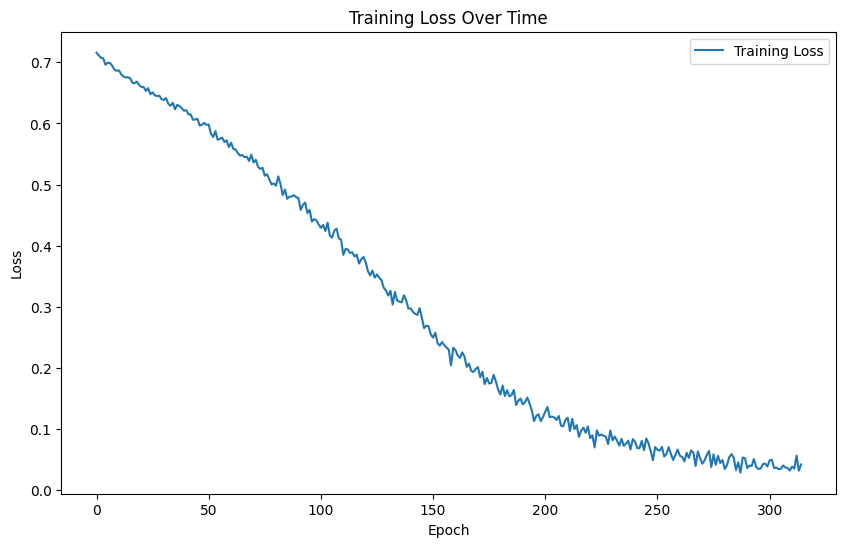

Best Epoch: 215
Confusion Matrix:
 [[54 21]
 [14 52]]

Classification Report:
               precision    recall  f1-score   support

     Class 0       0.79      0.72      0.76        75
     Class 1       0.71      0.79      0.75        66

    accuracy                           0.75       141
   macro avg       0.75      0.75      0.75       141
weighted avg       0.76      0.75      0.75       141

Best Test Accuracy: 0.7518


In [39]:
import random
import numpy as np
import torch

# 设置随机种子
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # 为所有GPU设置种子
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoConfig
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 加载下游任务数据集
file_path = 'data2.csv'
data2_df = pd.read_csv(file_path)

# 将数据集拆分为训练集和测试集
train_df, test_df = train_test_split(data2_df, test_size=0.2, random_state=seed)




# 使用上游模型生成增强表示的函数
def generate_enhanced_embeddings(texts, tokenizer, model):
    inputs = tokenizer(texts, padding=True, truncation=True, return_tensors="pt").to(device)
    outputs = model(**inputs)
    embeddings = outputs.hidden_states[-1][:, 0, :]
    predictions = torch.sigmoid(outputs.logits)
    enhanced_embeddings = torch.cat((embeddings, predictions), dim=1)
    return enhanced_embeddings

# 使用上游模型生成训练集和测试集的增强表示
model_path = "saved_model"
tokenizer = AutoTokenizer.from_pretrained(model_path)
config = AutoConfig.from_pretrained(model_path)
config.num_labels = 38  # 手动设置标签数量为 21
config.output_hidden_states = True
model = AutoModelForSequenceClassification.from_pretrained(model_path, config=config).to(device)

# 定义简单的二分类器
class SimpleClassifier(nn.Module):
    def __init__(self, input_dim):
        super(SimpleClassifier, self).__init__()
        self.linear = nn.Linear(input_dim, 1)
    
    def forward(self, x):
        return self.linear(x)

# 创建分类器实例
input_dim = config.hidden_size + config.num_labels
classifier = SimpleClassifier(input_dim).to(device)

# 将模型和分类器的参数放在同一个优化器中，并添加L2正则化
optimizer = optim.Adam(list(model.parameters()) + list(classifier.parameters()), lr=5e-5, weight_decay=1e-4)

# 定义损失函数
criterion = nn.BCEWithLogitsLoss()

# 记录损失值和测试集准确度
train_losses = []
test_accuracies = []

# 训练模型和分类器
num_epochs = 500
patience = 100  # 早停法的耐心值
best_accuracy = 0.0
best_epoch = 0
best_model_state = None
best_classifier_state = None
early_stop_counter = 0

model.train()
classifier.train()
for epoch in range(num_epochs):
    optimizer.zero_grad()
    train_embeddings = generate_enhanced_embeddings(train_df['compound'].tolist(), tokenizer, model)
    outputs = classifier(train_embeddings).squeeze()
    train_labels = torch.tensor(train_df['label'].values, dtype=torch.float).to(device)
    loss = criterion(outputs, train_labels)
    loss.backward()
    optimizer.step()
    
    train_losses.append(loss.item())

    # 计算测试集上的准确度
    model.eval()
    classifier.eval()
    with torch.no_grad():
        test_embeddings = generate_enhanced_embeddings(test_df['compound'].tolist(), tokenizer, model)
        test_outputs = classifier(test_embeddings).squeeze()
        test_labels = torch.tensor(test_df['label'].values, dtype=torch.float).to(device)
        test_predictions = torch.sigmoid(test_outputs) > 0.5
        accuracy = accuracy_score(test_labels.cpu(), test_predictions.cpu())
        test_accuracies.append(accuracy)
        
        # 记录最好的模型
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_epoch = epoch + 1
            torch.save(model.state_dict(),"best_model_state.pth")
            torch.save(classifier.state_dict(),"best_classifier_state.pth")
            early_stop_counter = 0  # 重置早停计数器
        else:
            early_stop_counter += 1  # 增加早停计数器
    
    model.train()
    classifier.train()
    
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item()}, Test Accuracy: {accuracy:.4f}")
    
    # 早停条件满足时停止训练
    if early_stop_counter >= patience:
        print("Early stopping triggered")
        break

# 绘制训练损失减少过程
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')
plt.legend()
plt.show()

# 加载测试集上效果最好的模型参数
model.load_state_dict(torch.load("best_model_state.pth", weights_only=True))
classifier.load_state_dict(torch.load("best_classifier_state.pth", weights_only=True))

# 在测试集上评估最好的模型
model.eval()
classifier.eval()
with torch.no_grad():
    test_embeddings = generate_enhanced_embeddings(test_df['compound'].tolist(), tokenizer, model)
    test_outputs = classifier(test_embeddings).squeeze()
    test_labels = torch.tensor(test_df['label'].values, dtype=torch.float).to(device)
    test_predictions = torch.sigmoid(test_outputs) > 0.5

# 计算混淆矩阵和其他评价指标
conf_matrix = confusion_matrix(test_labels.cpu(), test_predictions.cpu())
class_report = classification_report(test_labels.cpu(), test_predictions.cpu(), target_names=['Class 0', 'Class 1'])
accuracy = accuracy_score(test_labels.cpu(), test_predictions.cpu())

print("Best Epoch:", best_epoch)
print("Confusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", class_report)
print(f"Best Test Accuracy: {accuracy:.4f}")


In [73]:
#十倍交叉验证

In [75]:
import random
import numpy as np
import torch
from sklearn.model_selection import KFold

# 设置随机种子
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoConfig
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 加载下游任务数据集
file_path = 'data2.csv'
data2_df = pd.read_csv(file_path)

# 使用KFold进行十倍交叉验证
kf = KFold(n_splits=10, shuffle=True, random_state=seed)

# 记录交叉验证的结果
fold_accuracies = []
fold_conf_matrices = []
fold_class_reports = []

# 使用上游模型生成增强表示的函数
def generate_enhanced_embeddings(texts, tokenizer, model):
    inputs = tokenizer(texts, padding=True, truncation=True, return_tensors="pt").to(device)
    outputs = model(**inputs)
    embeddings = outputs.hidden_states[-1][:, 0, :]
    predictions = torch.sigmoid(outputs.logits)
    enhanced_embeddings = torch.cat((embeddings, predictions), dim=1)
    return enhanced_embeddings

# 加载预训练模型和分词器
model_path = "saved_model"
tokenizer = AutoTokenizer.from_pretrained(model_path)
config = AutoConfig.from_pretrained(model_path)
config.num_labels = 38  # 手动设置标签数量为 38
config.output_hidden_states = True
model = AutoModelForSequenceClassification.from_pretrained(model_path, config=config).to(device)

# 定义简单的二分类器
class SimpleClassifier(nn.Module):
    def __init__(self, input_dim):
        super(SimpleClassifier, self).__init__()
        self.linear = nn.Linear(input_dim, 1)
    
    def forward(self, x):
        return self.linear(x)

for fold, (train_index, test_index) in enumerate(kf.split(data2_df)):
    print(f"Fold {fold + 1}")

    train_df = data2_df.iloc[train_index]
    test_df = data2_df.iloc[test_index]

    # 创建分类器实例
    input_dim = config.hidden_size + config.num_labels
    classifier = SimpleClassifier(input_dim).to(device)

    # 将模型和分类器的参数放在同一个优化器中，并添加L2正则化
    optimizer = optim.Adam(list(model.parameters()) + list(classifier.parameters()), lr=5e-5, weight_decay=1e-4)

    # 定义损失函数
    criterion = nn.BCEWithLogitsLoss()

    # 记录损失值和测试集准确度
    train_losses = []
    test_accuracies = []

    # 训练模型和分类器
    num_epochs = 500
    patience = 100  # 早停法的耐心值
    best_accuracy = 0.0
    best_epoch = 0
    best_model_state = None
    best_classifier_state = None
    early_stop_counter = 0

    model.train()
    classifier.train()
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        train_embeddings = generate_enhanced_embeddings(train_df['compound'].tolist(), tokenizer, model)
        outputs = classifier(train_embeddings).squeeze()
        train_labels = torch.tensor(train_df['label'].values, dtype=torch.float).to(device)
        loss = criterion(outputs, train_labels)
        loss.backward()
        optimizer.step()
        
        train_losses.append(loss.item())

        # 计算测试集上的准确度
        model.eval()
        classifier.eval()
        with torch.no_grad():
            test_embeddings = generate_enhanced_embeddings(test_df['compound'].tolist(), tokenizer, model)
            test_outputs = classifier(test_embeddings).squeeze()
            test_labels = torch.tensor(test_df['label'].values, dtype=torch.float).to(device)
            test_predictions = torch.sigmoid(test_outputs) > 0.5
            accuracy = accuracy_score(test_labels.cpu(), test_predictions.cpu())
            test_accuracies.append(accuracy)
            
            # 记录最好的模型
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_epoch = epoch + 1
                best_model_state = model.state_dict()
                best_classifier_state = classifier.state_dict()
                early_stop_counter = 0  # 重置早停计数器
            else:
                early_stop_counter += 1  # 增加早停计数器
        
        model.train()
        classifier.train()
        
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item()}, Test Accuracy: {accuracy:.4f}")
        
        # 早停条件满足时停止训练
        if early_stop_counter >= patience:
            print("Early stopping triggered")
            break

    # 在当前fold上评估最好的模型
    model.load_state_dict(best_model_state)
    classifier.load_state_dict(best_classifier_state)

    model.eval()
    classifier.eval()
    with torch.no_grad():
        test_embeddings = generate_enhanced_embeddings(test_df['compound'].tolist(), tokenizer, model)
        test_outputs = classifier(test_embeddings).squeeze()
        test_labels = torch.tensor(test_df['label'].values, dtype=torch.float).to(device)
        test_predictions = torch.sigmoid(test_outputs) > 0.5

    # 计算混淆矩阵和其他评价指标
    conf_matrix = confusion_matrix(test_labels.cpu(), test_predictions.cpu())
    class_report = classification_report(test_labels.cpu(), test_predictions.cpu(), target_names=['Class 0', 'Class 1'])
    accuracy = accuracy_score(test_labels.cpu(), test_predictions.cpu())

    fold_accuracies.append(accuracy)
    fold_conf_matrices.append(conf_matrix)
    fold_class_reports.append(class_report)

    print("Best Epoch:", best_epoch)
    print("Confusion Matrix:\n", conf_matrix)
    print("\nClassification Report:\n", class_report)
    print(f"Best Test Accuracy: {accuracy:.4f}")

# 计算并输出交叉验证的平均结果
average_accuracy = np.mean(fold_accuracies)
average_conf_matrix = np.mean(fold_conf_matrices, axis=0)

print("\nCross-Validation Results:")
print("Average Accuracy:", average_accuracy)
print("Average Confusion Matrix:\n", average_conf_matrix)


Fold 1
Epoch 1/500, Loss: 0.7126027941703796, Test Accuracy: 0.4507
Epoch 2/500, Loss: 0.7075218558311462, Test Accuracy: 0.4648
Epoch 3/500, Loss: 0.7068123817443848, Test Accuracy: 0.4648
Epoch 4/500, Loss: 0.7088564038276672, Test Accuracy: 0.4648
Epoch 5/500, Loss: 0.7058301568031311, Test Accuracy: 0.4789
Epoch 6/500, Loss: 0.7012085318565369, Test Accuracy: 0.4930
Epoch 7/500, Loss: 0.6976335048675537, Test Accuracy: 0.4930
Epoch 8/500, Loss: 0.6914361715316772, Test Accuracy: 0.4648
Epoch 9/500, Loss: 0.6967139840126038, Test Accuracy: 0.4789
Epoch 10/500, Loss: 0.6897000670433044, Test Accuracy: 0.4648
Epoch 11/500, Loss: 0.6894508004188538, Test Accuracy: 0.4648
Epoch 12/500, Loss: 0.6874242424964905, Test Accuracy: 0.4930
Epoch 13/500, Loss: 0.6824612617492676, Test Accuracy: 0.4930
Epoch 14/500, Loss: 0.6813135743141174, Test Accuracy: 0.4930
Epoch 15/500, Loss: 0.6760850548744202, Test Accuracy: 0.5211
Epoch 16/500, Loss: 0.6756823062896729, Test Accuracy: 0.5211
Epoch 17/5